## Train & Test for Object Detection

In [6]:
%pip install torch torchvision --index-url https://download.pytorch.org/whl/cu121
%pip install albumentations pycocotools

Looking in indexes: https://download.pytorch.org/whl/cu121Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
print(f'Torch version: {torch.__version__}\n')

cuda = torch.cuda.is_available()
if cuda:
    print(f'CUDA is available')
    cuda_device = torch.cuda.current_device()
    print(torch.cuda.get_device_name(cuda_device))
    print(f'Compute capability: {torch.cuda.get_device_capability(cuda_device)}')
else:
    print('CUDA is not available')

Torch version: 2.3.1+cu121

CUDA is available
NVIDIA GeForce RTX 3050 Laptop GPU
Compute capability: (8, 6)


## Load Data


In [98]:
import os
from os.path import join

from PIL import Image
import numpy as np

import albumentations as A
from albumentations.pytorch import ToTensorV2

from torchvision import datasets


COCO_PATH = join(os.getcwd(), 'coco')
ANNOTATIONS_PATH = join(COCO_PATH, 'result.json')


# mask = Image.open('mask.png').convert('L')
# mask = np.array(mask)


def transformations(img, target):
 
    img = np.array(img)
    bboxes = [obj['bbox'] for obj in target]
    
    transform = A.Compose([
        # A.Crop(y_min=240, y_max=img.shape[0], x_min=0, x_max=img.shape[1]),
        A.Resize(256, 256),
        A.RandomBrightnessContrast(p=0.3),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ], bbox_params=A.BboxParams(format='coco', min_visibility=0.6, label_fields=['labels']))
    
    transformed = transform(image=img, bboxes=bboxes, labels=[obj['category_id'] for obj in target])
    
    target = {
        'boxes': torch.tensor(transformed['bboxes'], dtype=torch.float32),
        'labels': torch.tensor(transformed['labels'], dtype=torch.int64),
    }

    return transformed['image'], target


coco_dataset = datasets.CocoDetection(root=COCO_PATH, annFile=ANNOTATIONS_PATH, transforms=transformations)

CATEGORIES = {category_id: category_info['name'] for category_id, category_info in coco_dataset.coco.cats.items()}
print(CATEGORIES)

coco_default_dataset = datasets.CocoDetection(root=COCO_PATH, annFile=ANNOTATIONS_PATH)


loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
{0: 'Bicycle', 1: 'Bus', 2: 'Car', 3: 'Motor scooter', 4: 'Motorbike', 5: 'Pedestrian', 6: 'Scooter', 7: 'Truck'}
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


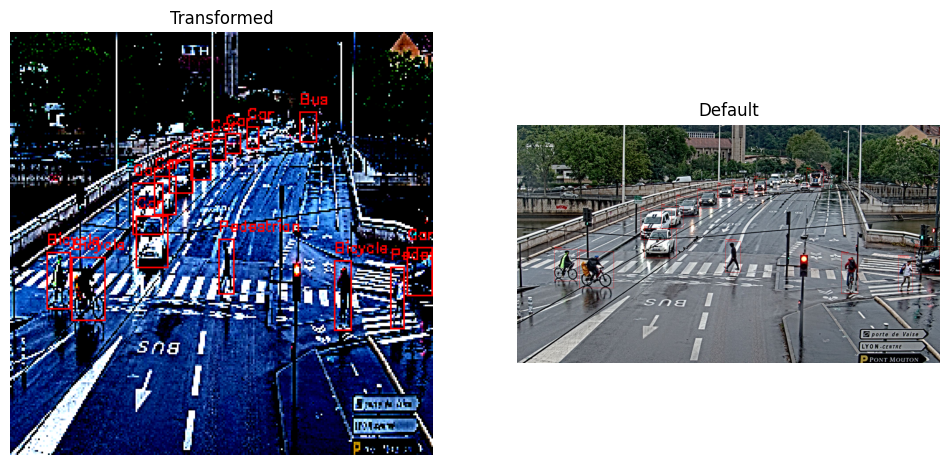

In [146]:
image1, annotations1 = coco_dataset[0]
image2, annotations2 = coco_default_dataset[0]


import matplotlib.pyplot as plt
import matplotlib.patches as patches

import cv2

from PIL import ImageDraw
from torchvision import transforms



def drawBoundingBoxes(image: Image.Image, boxes: torch.Tensor, labels: torch.Tensor):
    output = np.array(image)
    
    if output.shape[0] == 3:
        output = np.transpose(output, (1, 2, 0))
    
    for (x1, y1, x2, y2), label in zip(boxes, labels):
        x1, y1, x2, y2 = int(x1), int(y1), int(x1)+int(x2), int(y1)+int(y2)
        cv2.rectangle(output, (x1, y1), (x2, y2), (255, 0, 0), 1)
        cv2.putText(output, CATEGORIES[int(label)], (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), 1)
    return output




fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(drawBoundingBoxes(image1, annotations1['boxes'], annotations1['labels']))
axes[0].axis('off')
axes[0].set_title('Transformed')


axes[1].imshow(drawBoundingBoxes(image2, torch.tensor([obj['bbox'] for obj in annotations2]), torch.tensor([obj['category_id'] for obj in annotations2])))
axes[1].axis('off')
axes[1].set_title('Default')

plt.show()

## Preprocessing

- Resize the image to the desired size.
- Normalize the image.

In [ ]:
import json
import os
from os.path import join
from PIL import Image

from torch.utils.data import Dataset
from torchvision import datasets
from torchvision import transforms


COCO_PATH = join(os.getcwd(), 'coco')
ANNOTATIONS_PATH = join(COCO_PATH, 'result.json')


class CustomDataset(Dataset):
    def __init__(self, root, annotations, transform=None) -> None:
        self.root = root
        self.categories = self.loadCategories(annotations)
        self.annotations = self.loadAnnotations(annotations)
        self.transform = transform
        
    def loadCategories(self, path):
        with open(path, 'r') as f:
            data = json.load(f)
        
        parsed_categories = {}
        for category in data['categories']:
            parsed_categories[category['id']] = category['name']
        return parsed_categories
    
    def loadAnnotations(self, path):
        with open(path, 'r') as f:
            data = json.load(f)

        parsed_annotations = []
        for annotation in data['annotations']:
            image_id = annotation['image_id']
            category_id = annotation['category_id']
            image_path = data['images'][image_id]['file_name']
            bbox = annotation['bbox']

            parsed_annotations.append((image_id, category_id, image_path, bbox))

        return parsed_annotations

    def __getitem__(self, index):
        image_id, category_id, image_path, bbox = self.annotations[index]
        image = Image.open(join(self.root, image_path)).convert('RGB')
        bbox = [bbox['x_min'], bbox['y_min'], bbox['width'], bbox['height']]

        if self.transform:
            transformed = self.transform(image=image, bboxes=[bbox])
            image = transformed['image']
            bbox = transformed['bboxes'][0]

        return image, bbox, category_id

    def __len__(self):
        return len(self.annotations)


# transform = transforms.Compose([
#     transforms.Resize((256, 256)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])
# coco_dataset = datasets.CocoDetection(root=COCO_PATH, annFile=ANNOTATIONS_PATH, transform=transform)

dataset = CustomDataset(root=COCO_PATH, annotations=ANNOTATIONS_PATH)
print(len(dataset))
